# IMPORT DATASET

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, skew
import statsmodels.api as sm

calorie = pd.read_csv("train.csv")
test_original = pd.read_csv('test.csv')

# DATA VISUALIZATION

Let's preview the dataset:

In [4]:
calorie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [5]:
calorie.head()

id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

In [6]:
calorie.describe()

id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95.483995      40.036253      88.282781  
std         8.354095       9.449845       0.779875      62.395349  
min         1.000000      67.000000      37.100000       1.000000  
25%         8.000000      88.000000      39.600000      34.000000  
50%        15.000000      95.000000      40.300000      77.000000  
75%        23.000000     103.000000      40.700000     136.000000  
max        30.000000     128.000000      41.500000     314.000000

All seems great! There is no missing data here, and most the data is numerical, which make the process easier.

Let's see the distribution of some variable like: Age, Height, Weight, Heart_Rate, Body_Temp and Duration (duration of a workout).

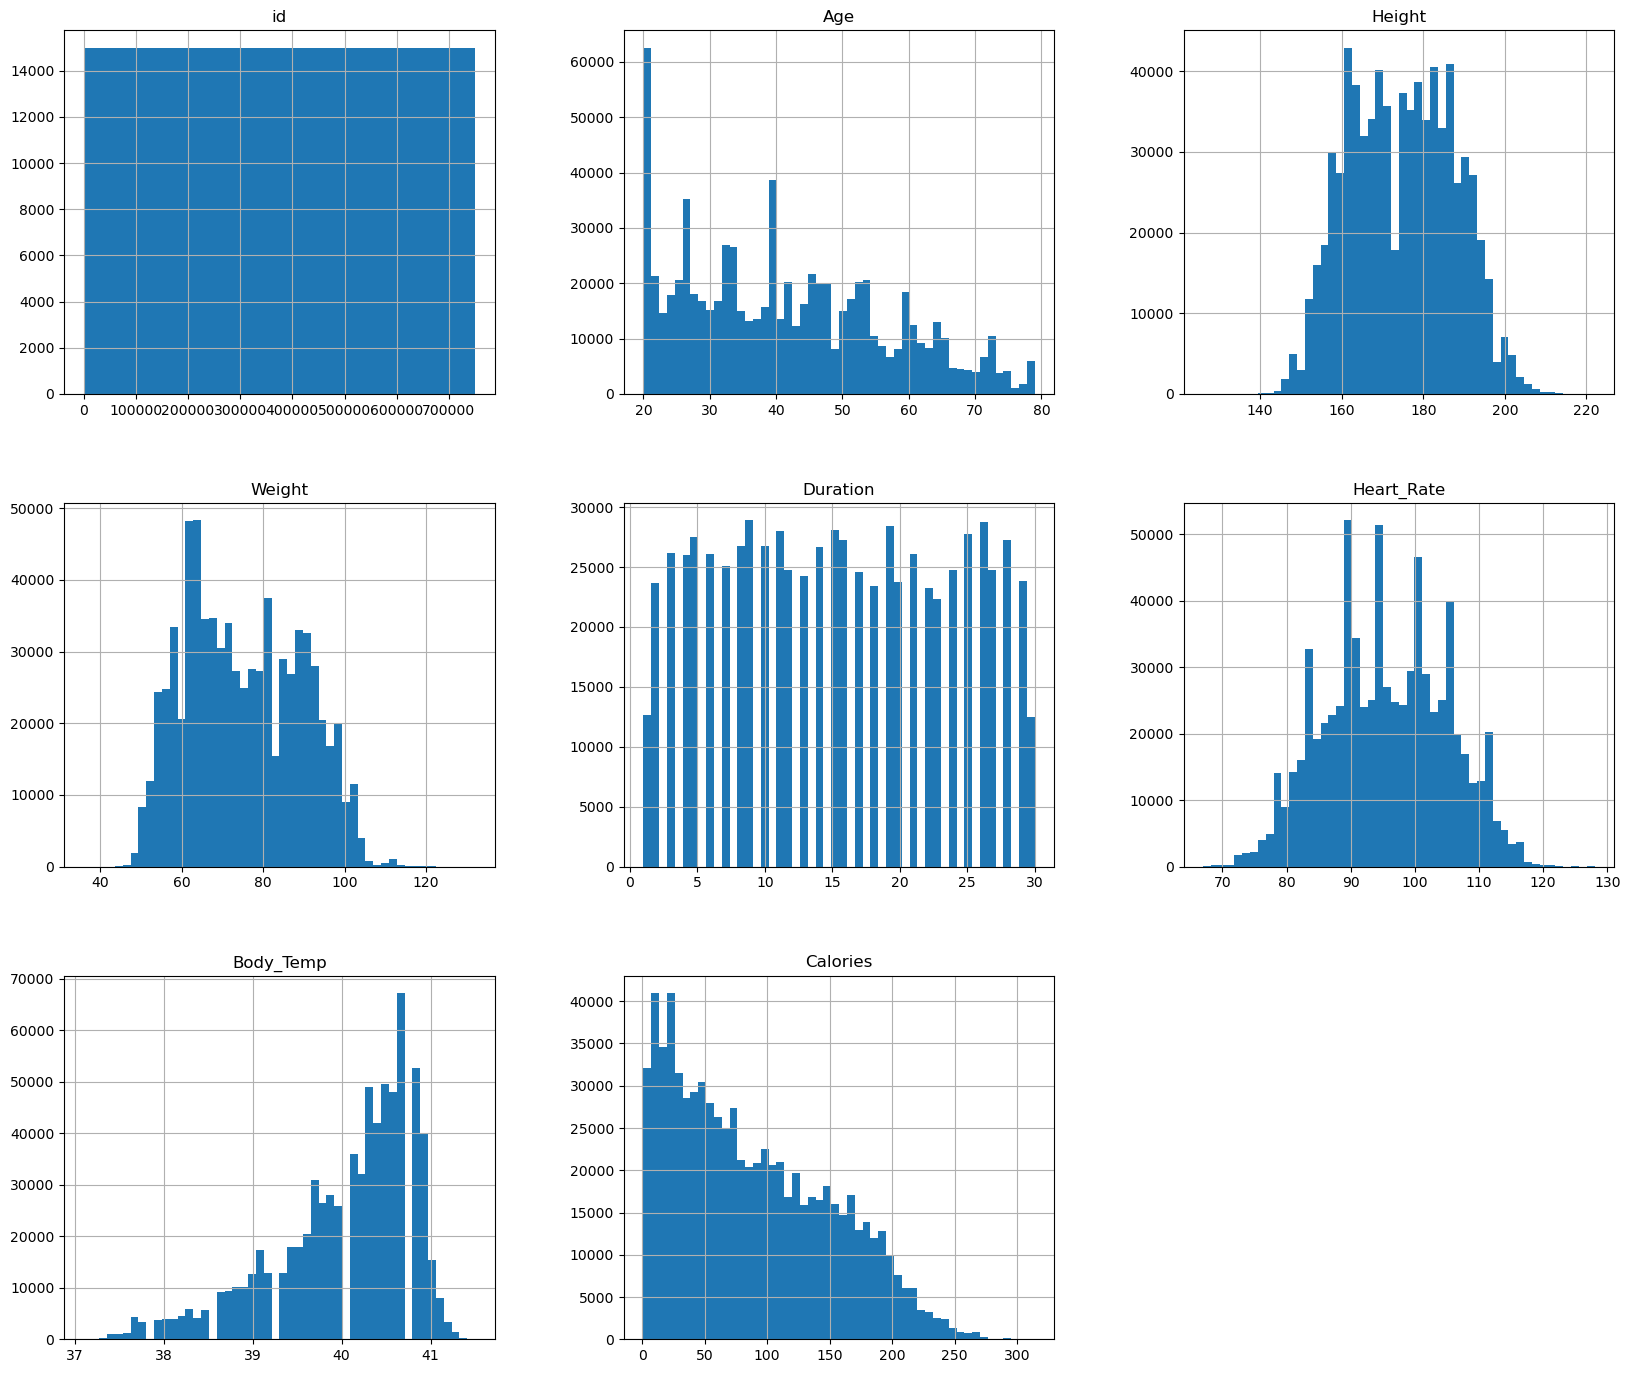

In [7]:
%matplotlib inline

calorie.hist(bins = 50, figsize = (20, 17))
plt.show() #Add comment to resolve

All seems good:
- Age: A large portion is around 20 years old and somewhat right-skewed, maybe because most of them doesn't have a job yet so the time they have is more than others.
- Height varies, but most likely is the joint combination of height distribution between male and female.
- Weight is slightly right skewed.
- Duration is nearly uniform.
- Heart Rate is close to normal distribution.
- Body Temp increase and stable as you exercise.
- Calories decrease as harder workout burn more calories - very right skewed.

# SPLIT TRAIN DATA AND LABELS

In [8]:
train_data = calorie.drop(['id', 'Calories'], axis = 1)
test_data = test_original.drop('id', axis = 1)

In [9]:
train_labels = calorie['Calories']

# DATA INVESTIGATION AND PREPARATION

## Investigate relationship between variables

Let's investigate to see which variable has the most impact on "Calories".

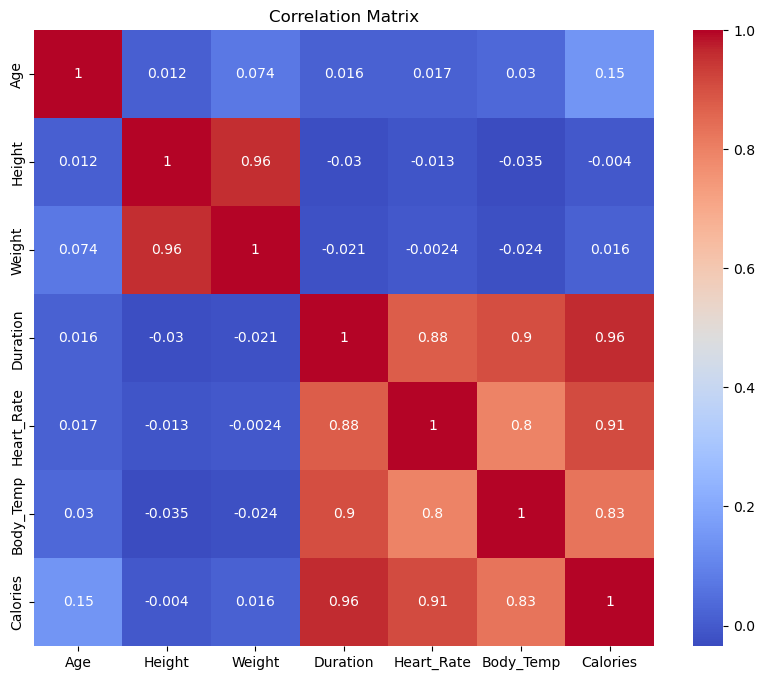

In [10]:
calorie_numerical_only = calorie.drop(['id', 'Sex'], axis = 1)
plt.figure(figsize=(10,8))
sns.heatmap(calorie_numerical_only.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
corr_matrix = calorie_numerical_only.corr()

corr_matrix["Calories"].sort_values(ascending = False)

Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64

Conclusion: Duration, Heart_Rate and Body_Temp are the most correlated feature here.

## Exploratory Data Analysis

Let's turn back to our correlation matrix:

In [12]:
train_eda = calorie.copy()

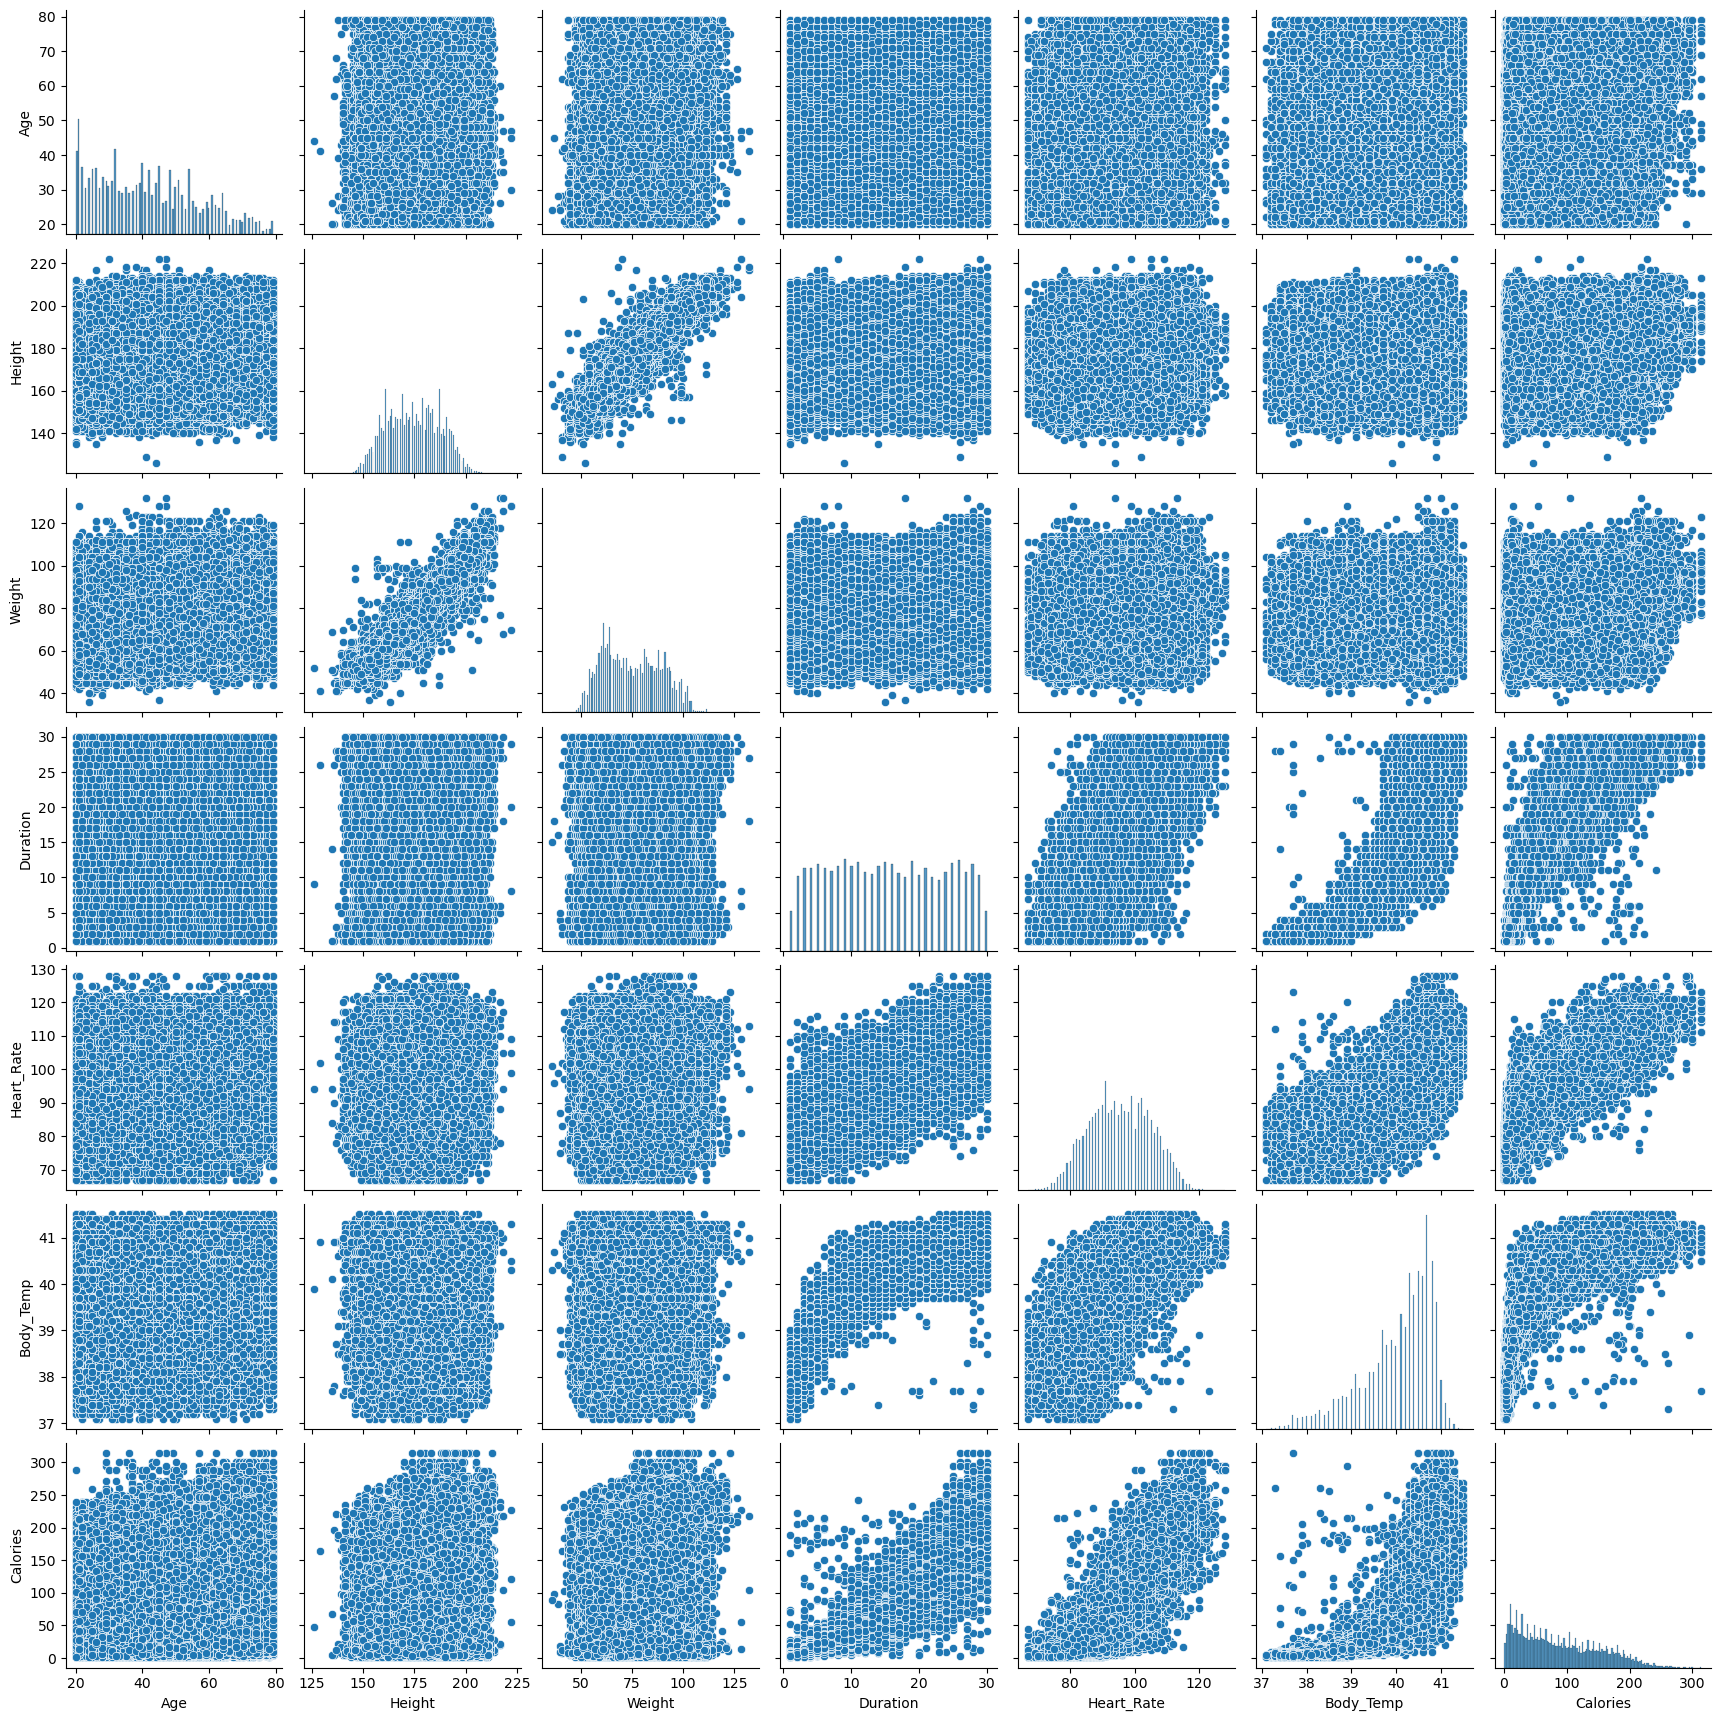

In [13]:
sns.pairplot(train_eda[['Age', "Height", 'Weight', 'Duration', 'Heart_Rate', "Body_Temp", 'Calories']])
plt.show()

We can see that calories may have a non-linear relationship with body_temp and likely linear with duration and heart_rate.

Let's investigate the target variable: calories

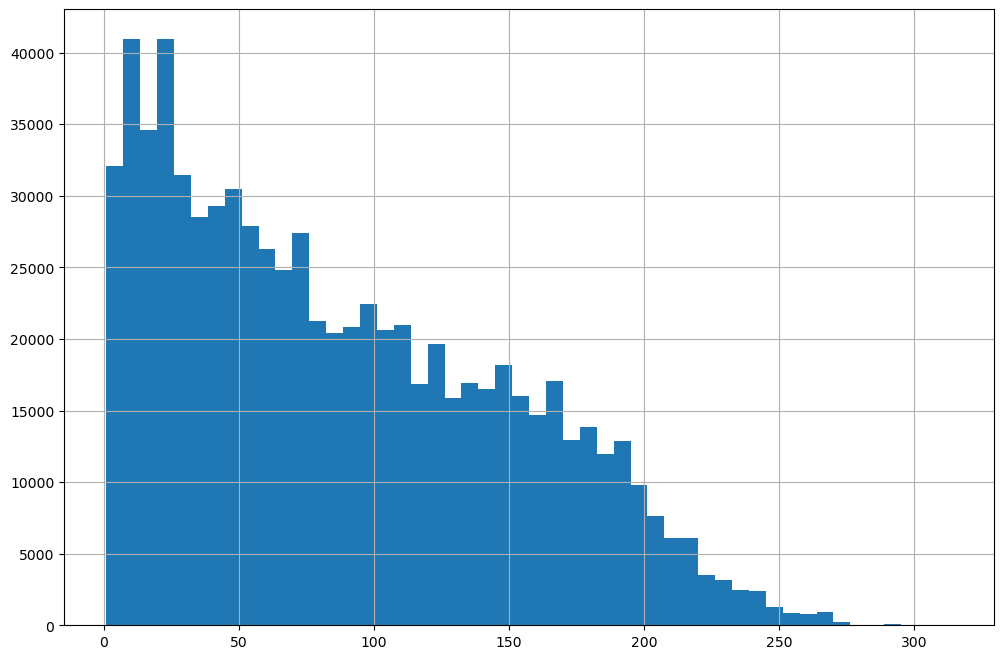

In [14]:
train_eda["Calories"].hist(bins = 50, figsize = (12, 8))
plt.show()

How will it look when being log-transformed?

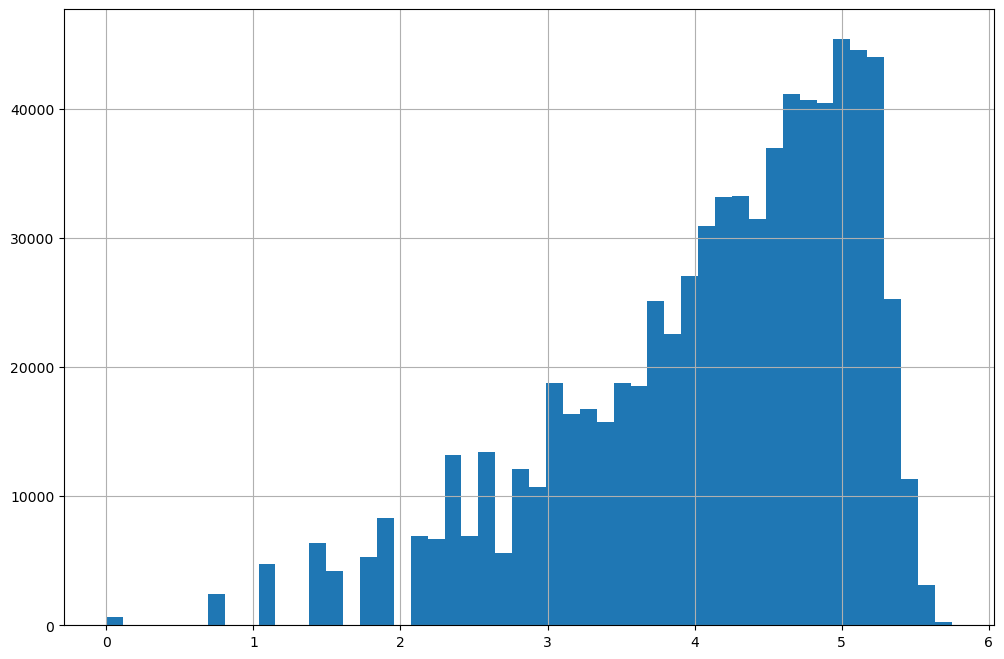

In [15]:
train_eda['Log_Calories'] = np.log(train_eda["Calories"])

train_eda["Log_Calories"].hist(bins = 50, figsize = (12, 8))
plt.show()

We can see log-transformation doesn't help much because our most of our data is tightly packed at the low end.

Let's try to apply a Box-Cox transformation:

In [16]:
train_eda["BoxCox_Calories"], lambda_optimal = boxcox(train_eda["Calories"])

print("Optimal lambda:", lambda_optimal)
print("Skewness before:", skew(train_eda["Calories"]))
print("Skewness after:", skew(train_eda["BoxCox_Calories"]))

Optimal lambda: 0.43889982917838444
Skewness before: 0.5391951861298309
Skewness after: -0.15035416885364059


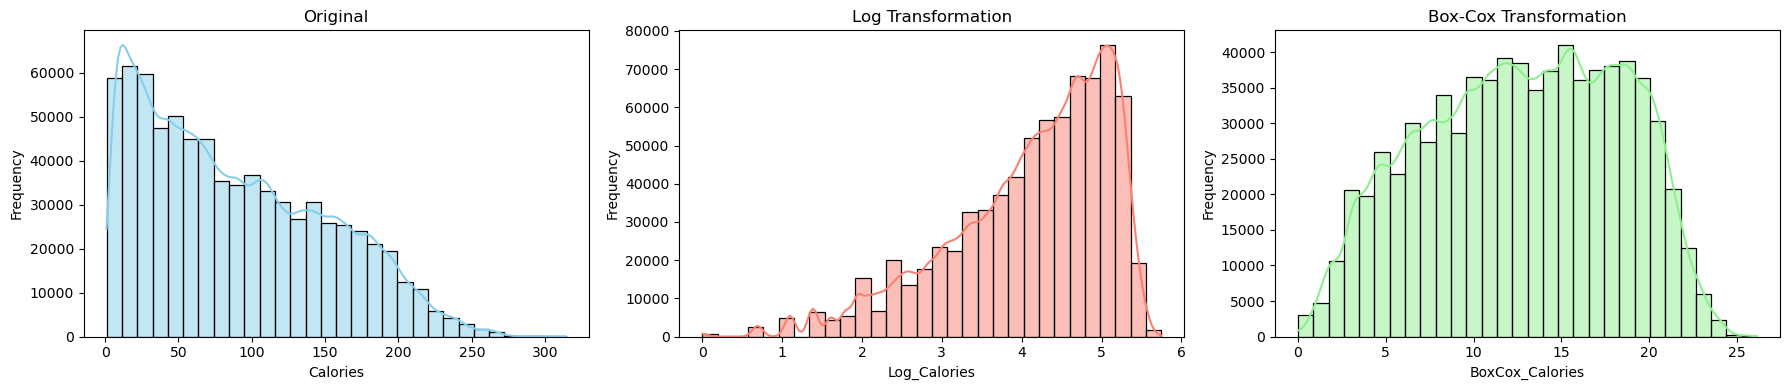

In [17]:
plt.figure(figsize=(18, 4))

# Plot 1: Original
plt.subplot(1, 3, 1)
sns.histplot(train_eda["Calories"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Original")
plt.xlabel("Calories")
plt.ylabel("Frequency")

# Plot 2: Log Transformation
plt.subplot(1, 3, 2)
sns.histplot(train_eda["Log_Calories"], bins=30, kde=True, color='salmon', edgecolor='black')
plt.title("Log Transformation")
plt.xlabel("Log_Calories")
plt.ylabel("Frequency")

# Plot 3: Box-Cox
plt.subplot(1, 3, 3)
sns.histplot(train_eda["BoxCox_Calories"], bins=30, kde=True, color='lightgreen', edgecolor='black')
plt.title("Box-Cox Transformation")
plt.xlabel("BoxCox_Calories")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

We can see that it's produce a much better result. Let's proceed with Box Cox transformation.

### Calories vs Body_Temp

Let's see if the boxcox can turn the relationship between Body_Temp and Calories into a linear relationship:

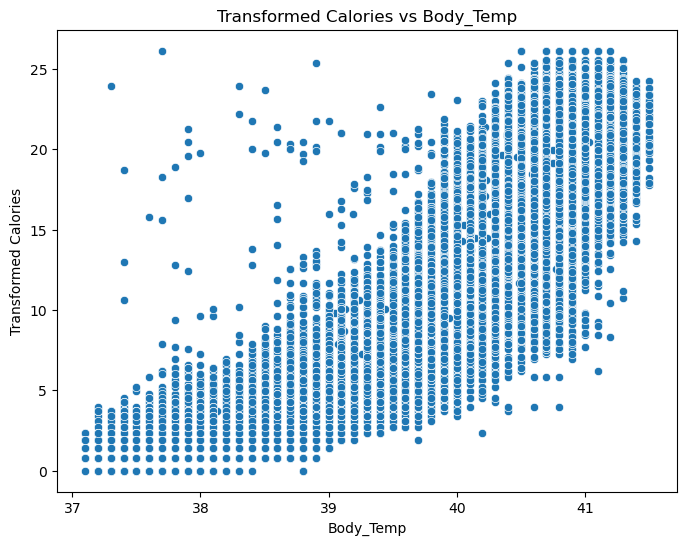

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Body_Temp', y='BoxCox_Calories', data=train_eda)
plt.title('Transformed Calories vs Body_Temp')
plt.xlabel('Body_Temp')
plt.ylabel('Transformed Calories')
plt.show()

We can see this is likely to be linear. Let's build a simple linear model to test our hypothesis:

In [19]:

#Create a linear model
X = train_eda['Body_Temp']
y = train_eda['BoxCox_Calories']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        BoxCox_Calories   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 3.903e+06
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        12:56:03   Log-Likelihood:            -1.6617e+06
No. Observations:              750000   AIC:                         3.323e+06
Df Residuals:                  749998   BIC:                         3.324e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -247.0103      0.132  -1878.120      0.0

We achieve the model:

BoxCox_Calories=−247.01+6.489×Body_Temp

With p-value of both coefficient p ~ 0.000, which is significant for us to conclude that there is a strong relationship between these two variable.

Conclusion: Every 1°C increase in body temperature increases BoxCox_Calories burn by about 6.489 units.

Let's see how BoxCox_Calories perform with other variables:

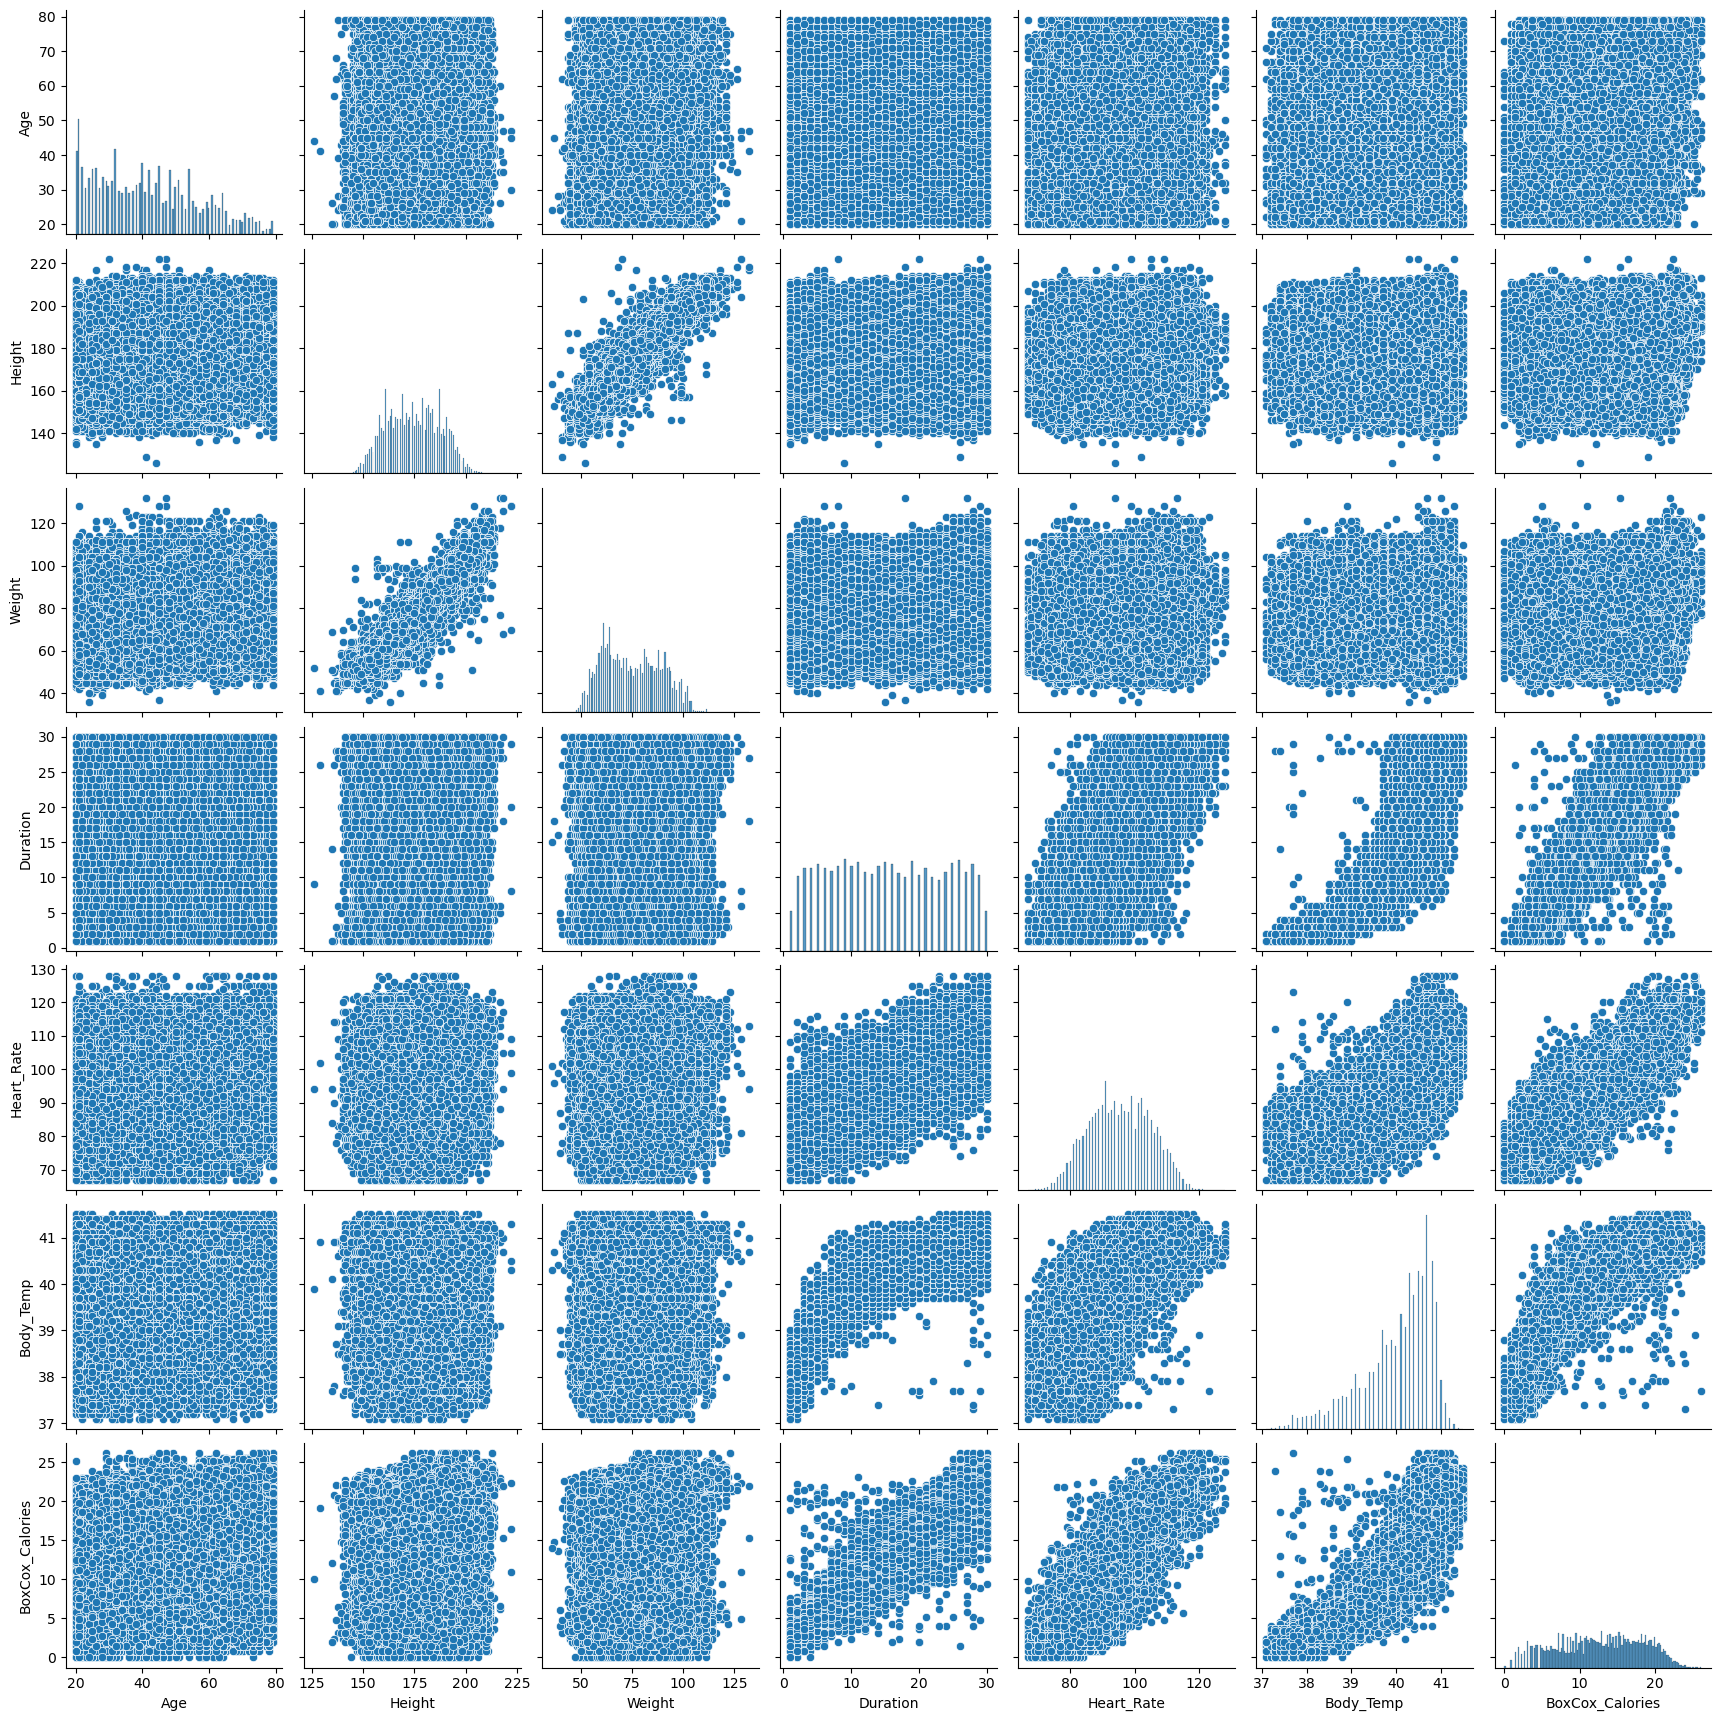

In [20]:
sns.pairplot(train_eda[['Age', "Height", 'Weight', 'Duration', 'Heart_Rate', "Body_Temp", 'BoxCox_Calories']])
plt.show()

We can see with BoxCox_Calories: Duration, Heart_Rate and Body_Temp all seems to have a better linear relationship compare to original Calories.

Let's see the histogram and boxplot of each variable:

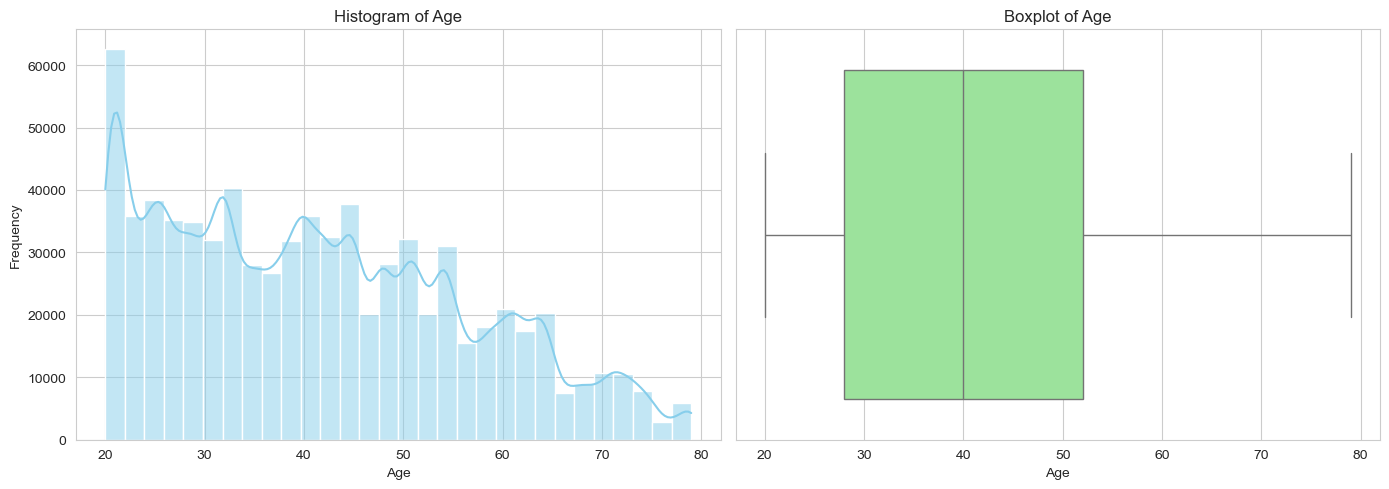

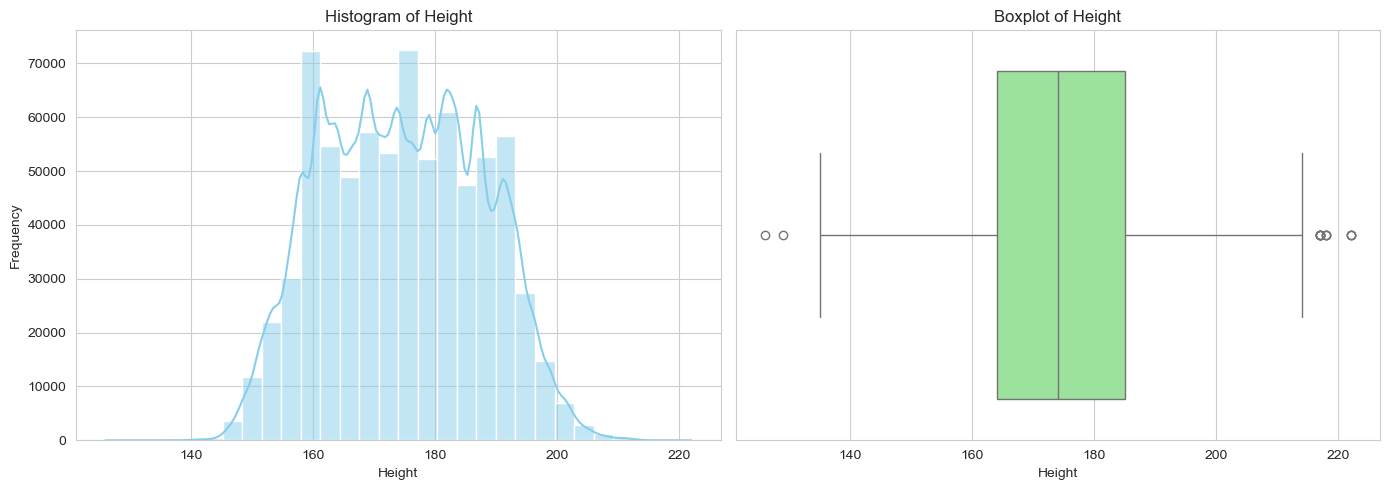

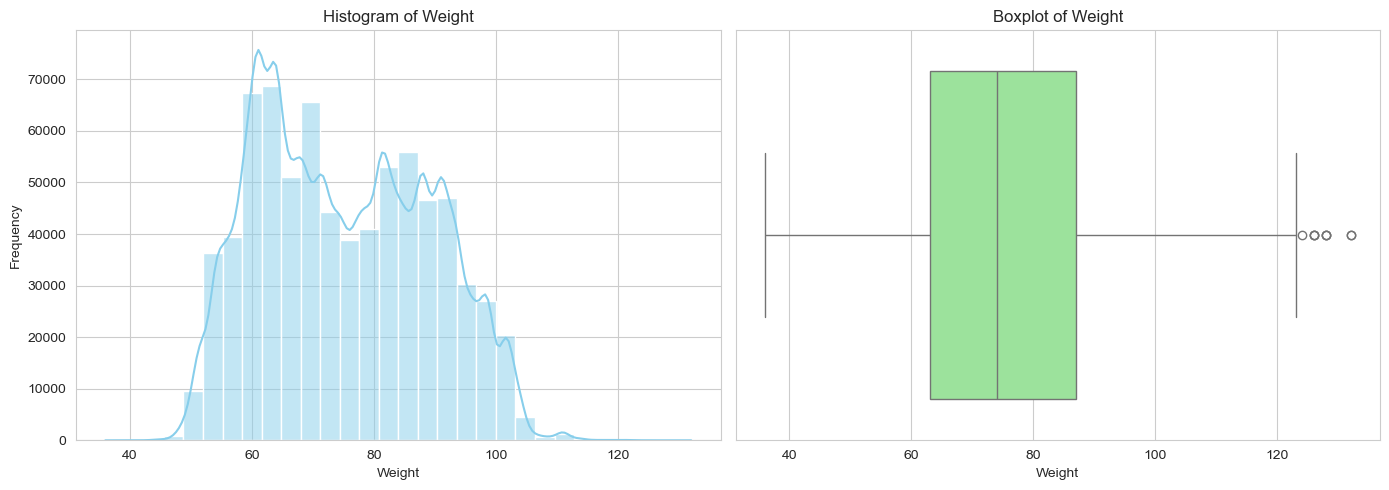

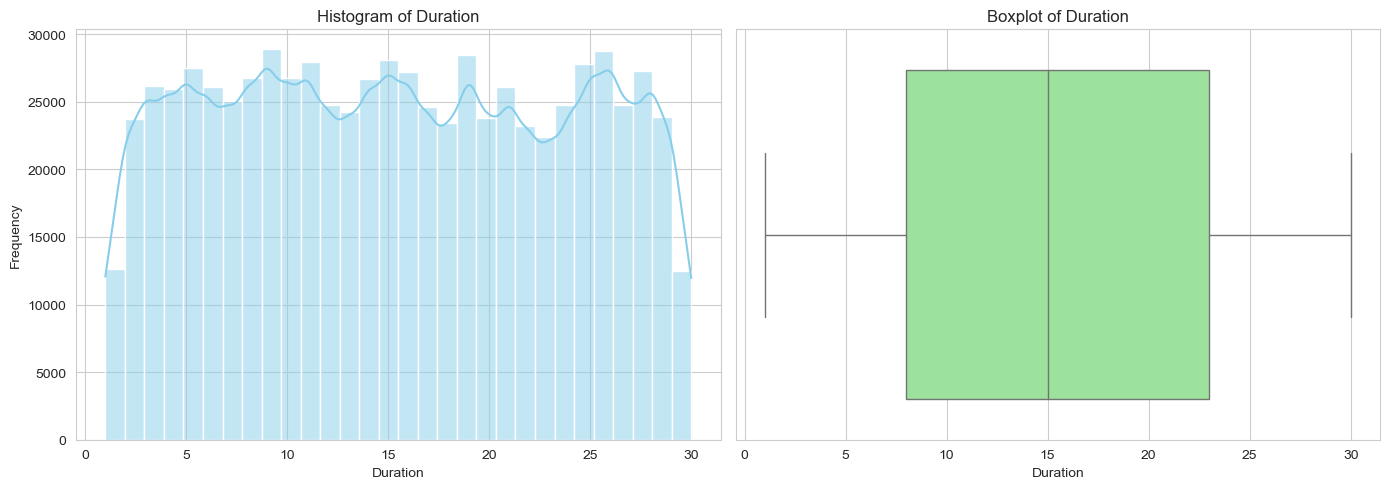

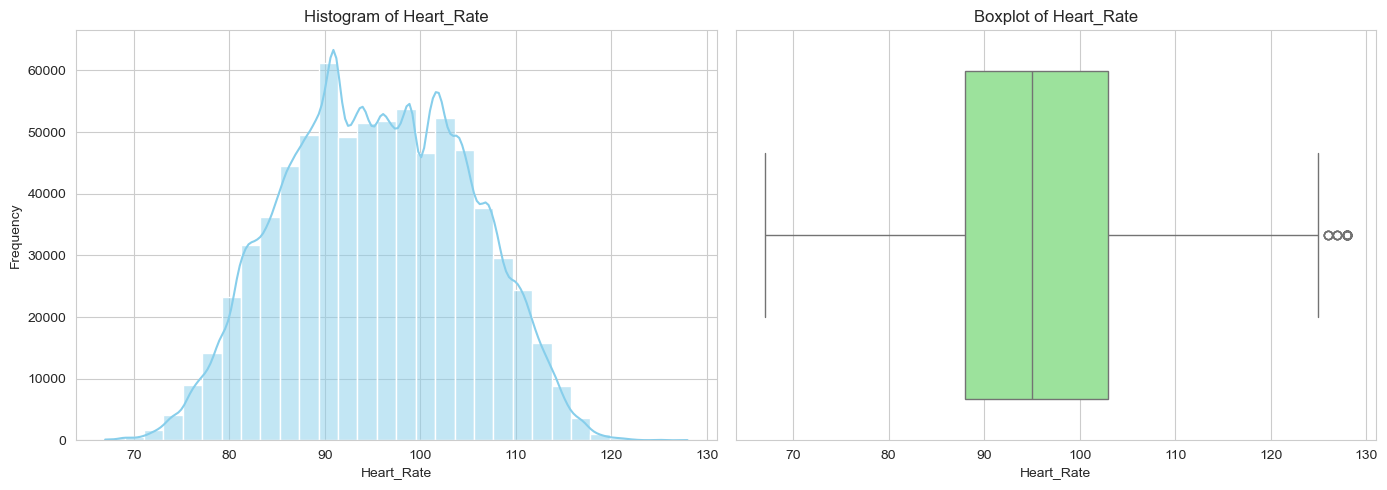

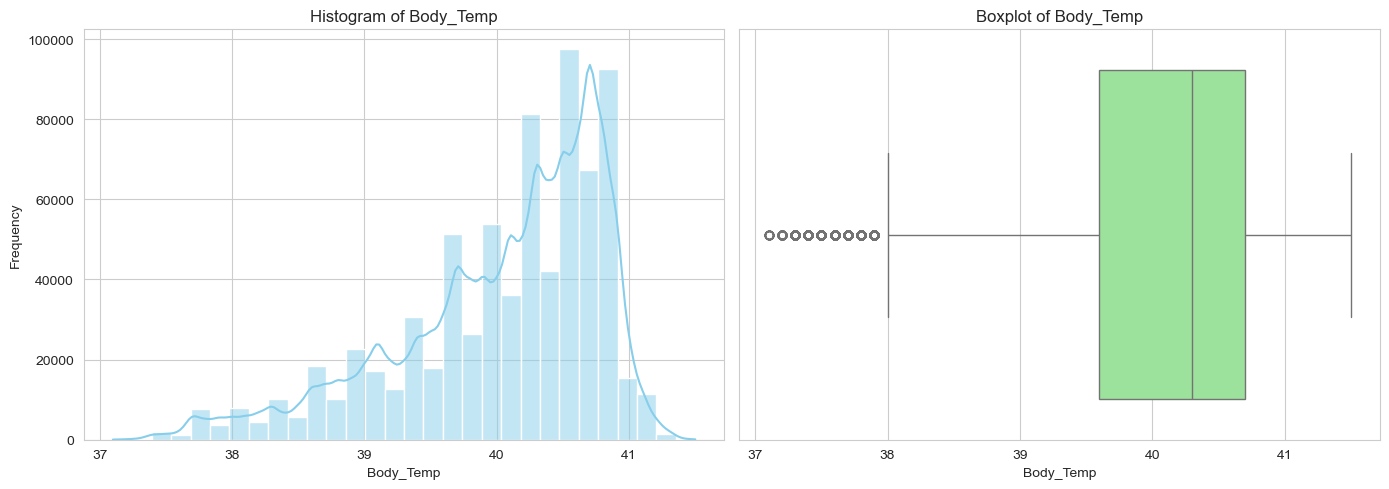

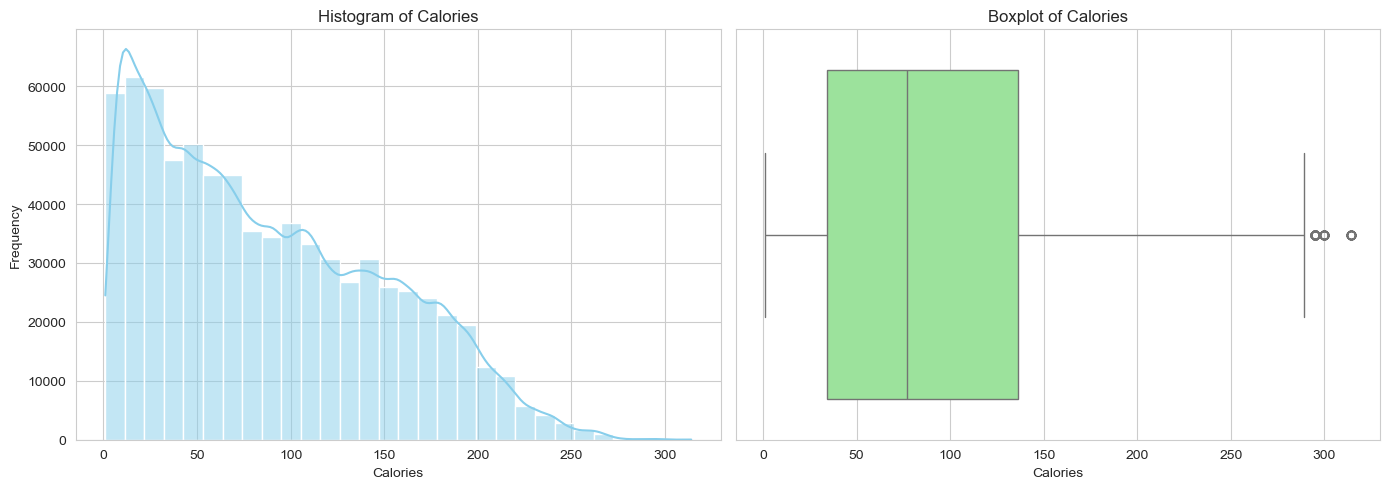

In [21]:
columns = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

sns.set_style(style="whitegrid")

for col in columns:
    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(train_eda[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_eda[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


- Age: Log transformation
- Height: Do nothing
- Weight: Log transformation
- Duration: Do nothing / create a new variable for bin duration (e.g < 5 mins, 5-10 mins, etc)
- Heart_Rate: Do nothing
- Body_Temp: Do nothing (Standardize)

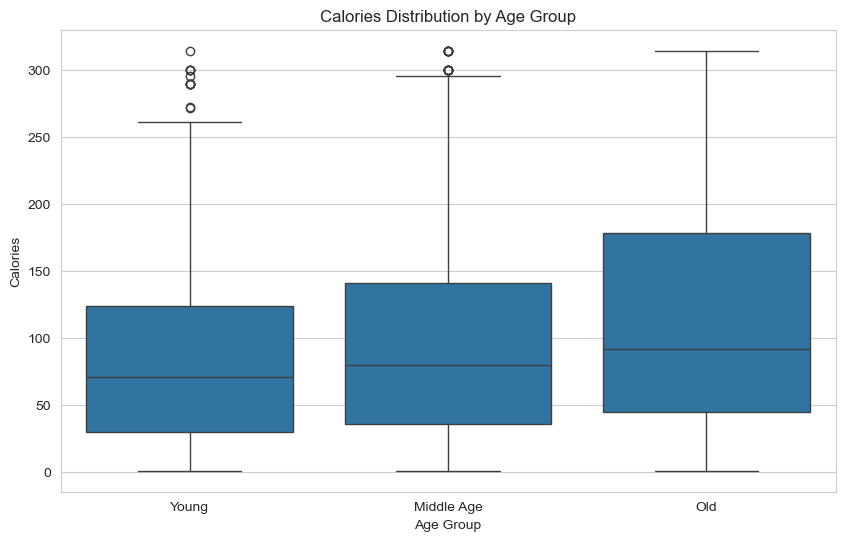

In [22]:
age_bins = [20, 35, 65, 80]
age_labels = ['Young', 'Middle Age', 'Old']

train_eda['Age_Grp'] = pd.cut(train_eda['Age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Grp', y='Calories', data=train_eda)
plt.title('Calories Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Calories')
plt.show()

This suggest the like of the more you get old, the more calories you burn.

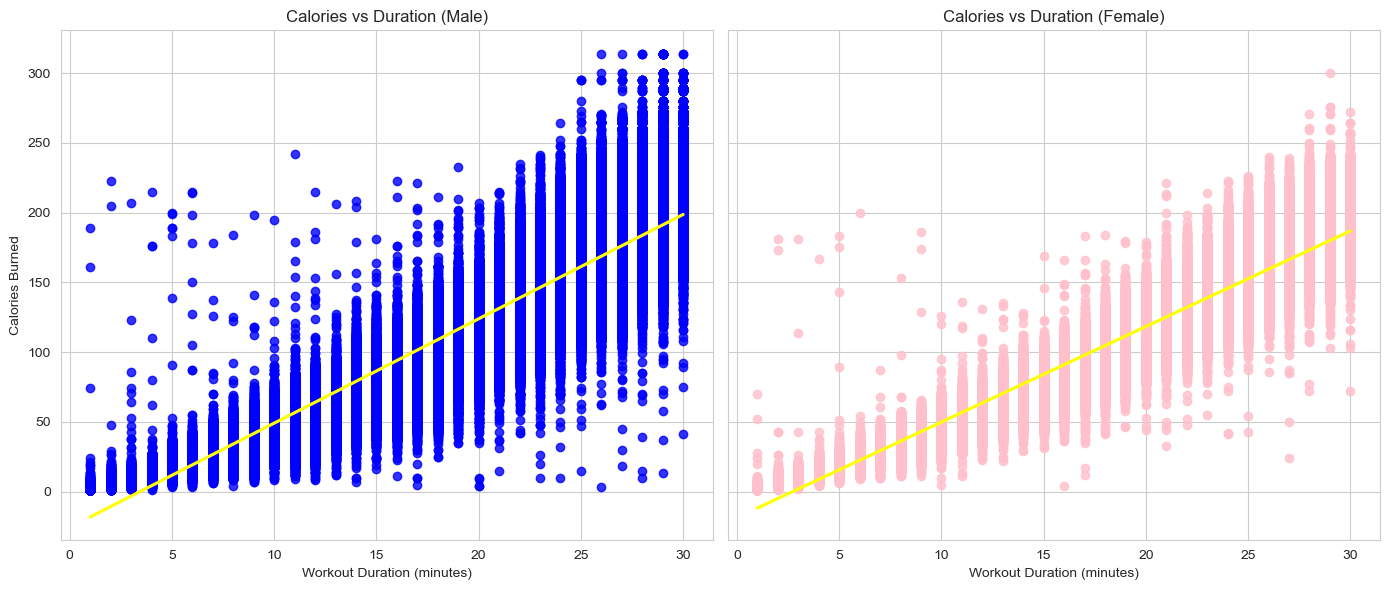

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Male plot with regression line
male_data = calorie[calorie['Sex'] == 'male']
sns.regplot(x='Duration', y='Calories', data=male_data, ax=axes[0],
           scatter_kws={'color': 'blue'}, line_kws={'color': 'yellow'})
axes[0].set_title('Calories vs Duration (Male)')
axes[0].set_xlabel('Workout Duration (minutes)')
axes[0].set_ylabel('Calories Burned')

# Female plot with regression line
female_data = calorie[calorie['Sex'] == 'female']
sns.regplot(x='Duration', y='Calories', data=female_data, ax=axes[1],
           scatter_kws={'color': 'pink'}, line_kws={'color': 'yellow'})
axes[1].set_title('Calories vs Duration (Female)')
axes[1].set_xlabel('Workout Duration (minutes)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

From this graph, we can see that both duration and calories burned of men have higher range compared to that of women.

## Feature Engineering
Let's try to create some new variable that may be useful:
- BMI (Body Mass Index) = Weight / (Height ** 2) (Weight in kg, Height in m)
- Interactive terms: Weight * Duration
- Interactive terms: Duration * Body_Temp
- Interactive terms: Heart_Rate * Body_Temp (Suggesting that higher heart rate could lead to higher body temperature)
- Interactive terms: Duration * Heart_Rate

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y= None):

        if hasattr(X, 'loc'):
            BMI = X['Weight'] / ((X['Height'] / 100) ** 2)
            duration_weight = X['Duration'] * X['Weight']
            duration_bodytemp = X['Duration'] * X["Body_Temp"]
            duration_heartrate = X['Duration'] * X['Heart_Rate']
            heartrate_bodytemp = X['Heart_Rate'] * X["Body_Temp"]
            X = X.copy()
            X['BMI'] = BMI
            X['Duration_Weight'] = duration_weight
            X['Duration_Bodytemp'] = duration_bodytemp
            X['Duration_Heartrate'] = duration_heartrate
            X['Heartrate_Bodytemp'] = heartrate_bodytemp
            return X
        else:
            print("Error please check that input is DataFrame!")

This code allow us to calculate new variables.

Let's try and see how the variables are distributed.

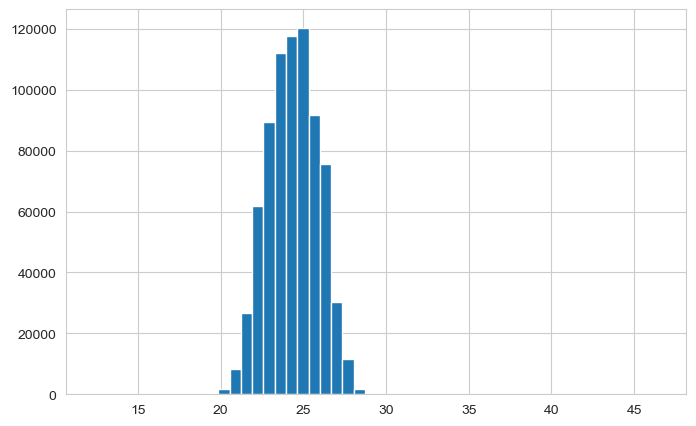

In [25]:
adder = AttributeAdder()
train_ver1 = adder.transform(calorie)
train_ver1['BMI'].hist(bins=50, figsize=(8, 5))
plt.show()

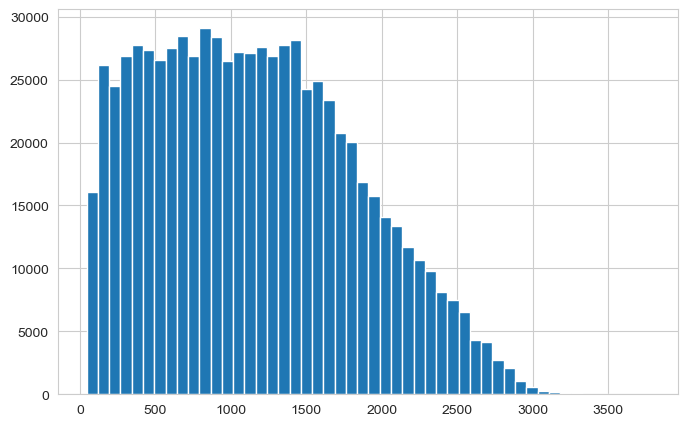

In [26]:
train_ver1["Duration_Weight"].hist(bins = 50, figsize = (8, 5))
plt.show()

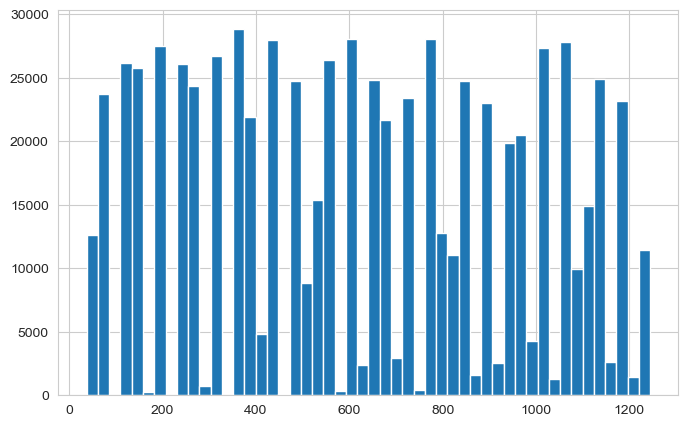

In [27]:
train_ver1['Duration_Bodytemp'].hist(bins = 50, figsize=(8,5))
plt.show()

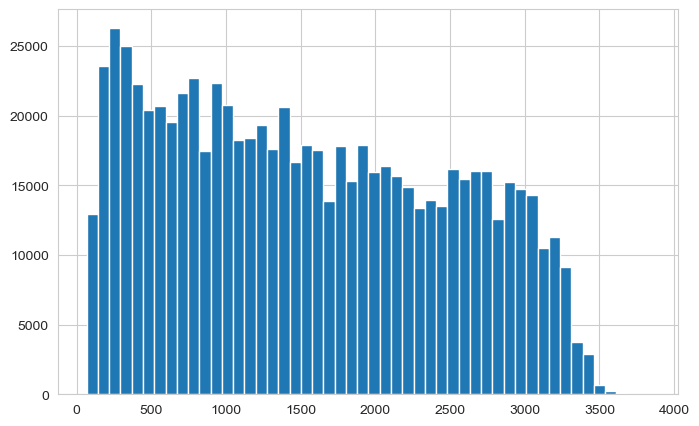

In [28]:
train_ver1["Duration_Heartrate"].hist(bins = 50, figsize=(8,5))
plt.show()

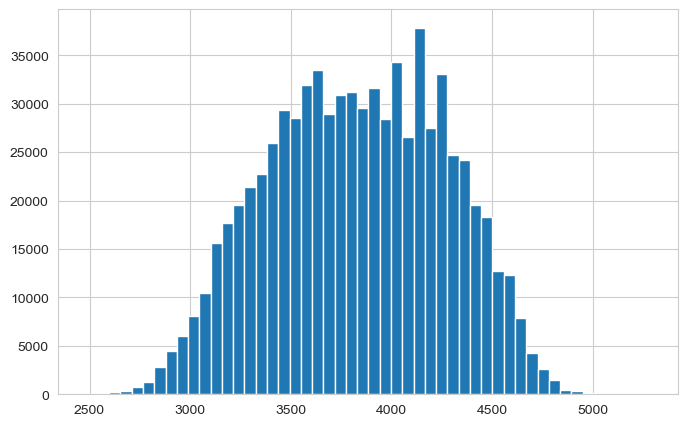

In [29]:
train_ver1["Heartrate_Bodytemp"].hist(bins=50, figsize=(8,5))
plt.show()

BMI and Heartrate_BodyTemp seems to have distribution close to normal distribution while other with Duration involve tends to have a close to uniform distribution.

In [30]:
train_ver1['BoxCox_Calories'], lambda_optimal = boxcox(train_ver1["Calories"])

In [31]:
train_ver1_numerical_only = train_ver1.drop(['id', 'Sex'], axis = 1)
corr_matrix = train_ver1_numerical_only.corr()

corr_matrix['BoxCox_Calories'].sort_values(ascending=False)

BoxCox_Calories       1.000000
Duration_Heartrate    0.976629
Duration              0.976505
Duration_Bodytemp     0.976038
Calories              0.972662
Heartrate_Bodytemp    0.943871
Duration_Weight       0.918481
Heart_Rate            0.918029
Body_Temp             0.915875
Age                   0.129474
BMI                   0.030851
Weight               -0.008379
Height               -0.026502
Name: BoxCox_Calories, dtype: float64

In [32]:
corr_matrix["Calories"].sort_values(ascending = False)

Calories              1.000000
Duration_Heartrate    0.977341
BoxCox_Calories       0.972662
Duration_Bodytemp     0.960909
Duration              0.959908
Heartrate_Bodytemp    0.924599
Duration_Weight       0.912617
Heart_Rate            0.908748
Body_Temp             0.828671
Age                   0.145683
BMI                   0.049226
Weight                0.015863
Height               -0.004026
Name: Calories, dtype: float64

It's seems like all variables show a better relationship with BoxCox_Calories compared to the original Calories.

Especially Duration_Heartrate, Duration, Duration_BodyTemp all have very good correlation coefficient.

Let's see the relationship between Duration_BodyTemp and calories:

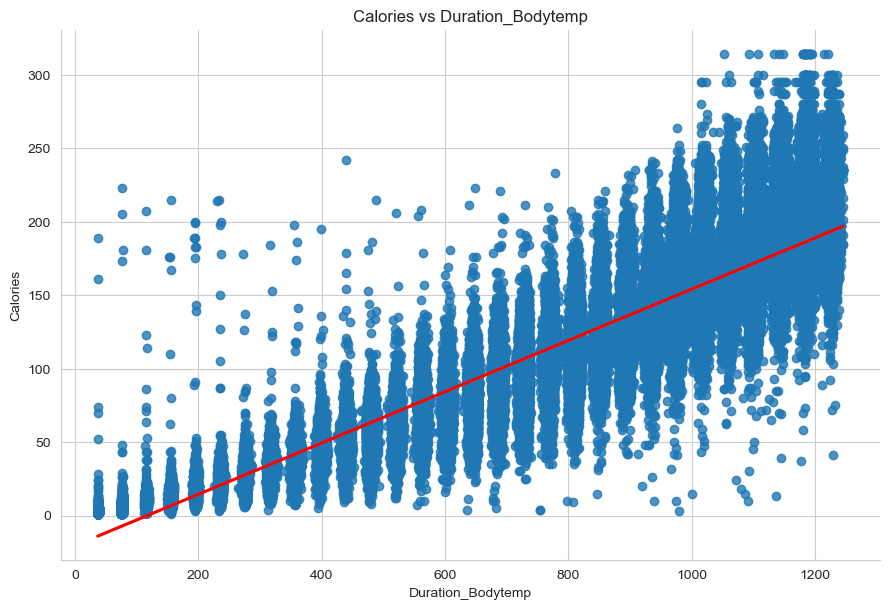

In [33]:
sns.lmplot(
    x='Duration_Bodytemp',
    y='Calories',
    data=train_ver1,
    height=6,
    aspect=1.5,
    line_kws={'color': 'red'}
)
plt.title('Calories vs Duration_Bodytemp')
plt.show()

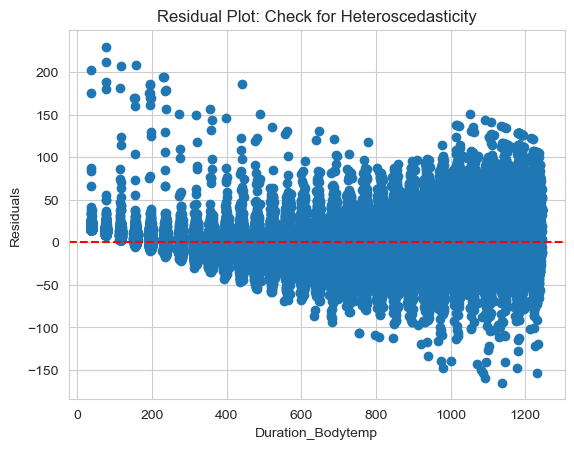

In [34]:
X = sm.add_constant(train_ver1['Duration_Bodytemp'])
y = train_ver1['Calories']

model = sm.OLS(y, X).fit()
residuals = model.resid

plt.scatter(train_ver1['Duration_Bodytemp'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Duration_Bodytemp')
plt.ylabel('Residuals')
plt.title('Residual Plot: Check for Heteroscedasticity')
plt.show()

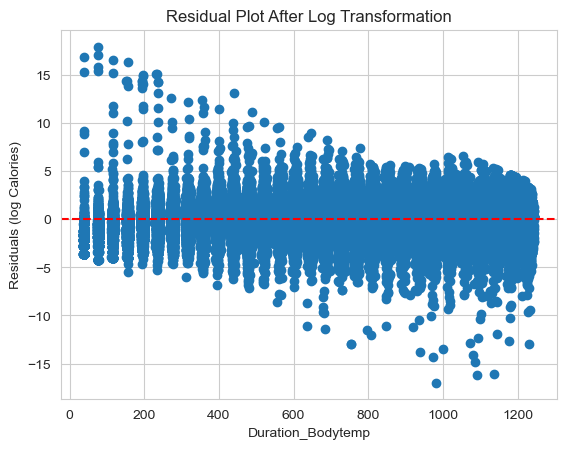

In [35]:
y_boxcox = train_ver1["BoxCox_Calories"]

model_boxcox = sm.OLS(y_boxcox, X).fit()
residuals_log = model_boxcox.resid

plt.scatter(train_ver1['Duration_Bodytemp'], residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Duration_Bodytemp')
plt.ylabel('Residuals (log Calories)')
plt.title('Residual Plot After Log Transformation')
plt.show()

How about heteroscedasticity of transformed_calories compare with other variable?

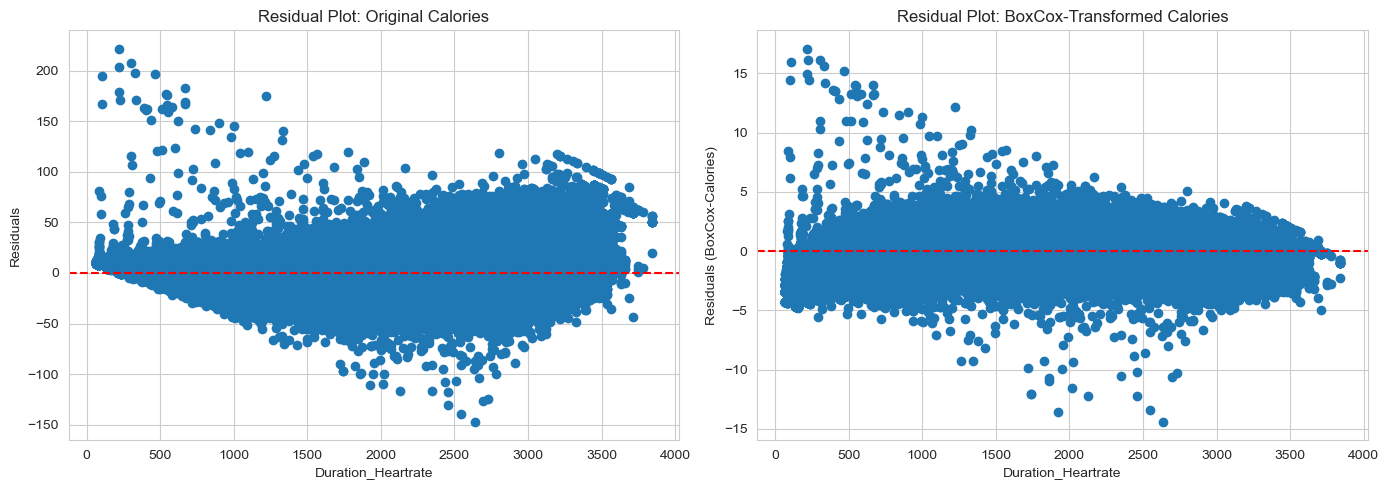

In [36]:
X = sm.add_constant(train_ver1['Duration_Heartrate'])
y = train_ver1['Calories']
model = sm.OLS(y, X).fit()
residuals = model.resid

y_log = train_ver1["BoxCox_Calories"]
model_log = sm.OLS(y_log, X).fit()
residuals_log = model_log.resid

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(train_ver1['Duration_Heartrate'], residuals)
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel('Duration_Heartrate')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residual Plot: Original Calories')

axs[1].scatter(train_ver1['Duration_Heartrate'], residuals_log)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_xlabel('Duration_Heartrate')
axs[1].set_ylabel('Residuals (BoxCox-Calories)')
axs[1].set_title('Residual Plot: BoxCox-Transformed Calories')

plt.tight_layout()
plt.show()

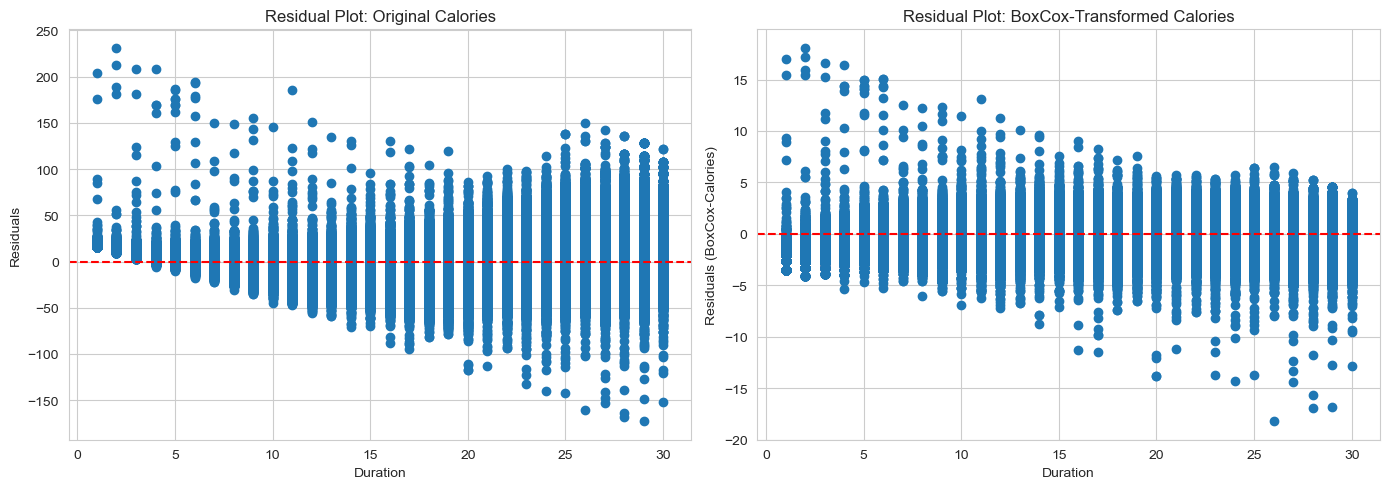

In [37]:
X = sm.add_constant(train_ver1['Duration'])
y = train_ver1['Calories']
model = sm.OLS(y, X).fit()
residuals = model.resid

y_log = train_ver1["BoxCox_Calories"]
model_log = sm.OLS(y_log, X).fit()
residuals_log = model_log.resid

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(train_ver1['Duration'], residuals)
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel('Duration')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residual Plot: Original Calories')

axs[1].scatter(train_ver1['Duration'], residuals_log)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_xlabel('Duration')
axs[1].set_ylabel('Residuals (BoxCox-Calories)')
axs[1].set_title('Residual Plot: BoxCox-Transformed Calories')

plt.tight_layout()
plt.show()

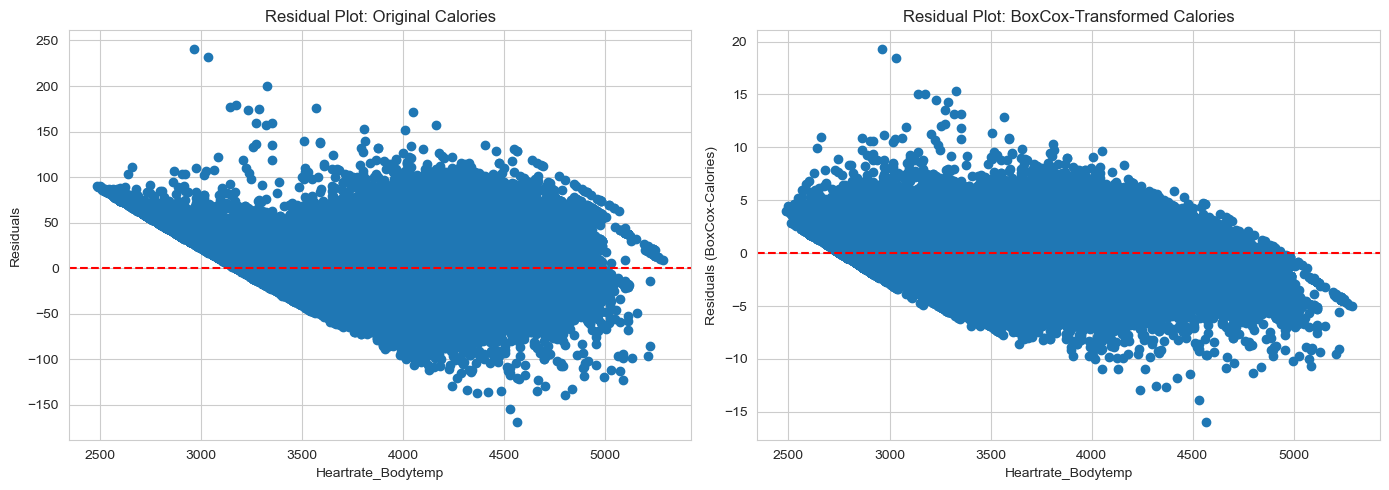

In [38]:
X = sm.add_constant(train_ver1['Heartrate_Bodytemp'])
y = train_ver1['Calories']
model = sm.OLS(y, X).fit()
residuals = model.resid

y_log = train_ver1["BoxCox_Calories"]
model_log = sm.OLS(y_log, X).fit()
residuals_log = model_log.resid

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(train_ver1['Heartrate_Bodytemp'], residuals)
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel('Heartrate_Bodytemp')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residual Plot: Original Calories')

axs[1].scatter(train_ver1['Heartrate_Bodytemp'], residuals_log)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_xlabel('Heartrate_Bodytemp')
axs[1].set_ylabel('Residuals (BoxCox-Calories)')
axs[1].set_title('Residual Plot: BoxCox-Transformed Calories')

plt.tight_layout()
plt.show()

BoxCox-Calories have superior, much better heteroscedasticity compare to original calories.

**Conclusion:**
We'll use BoxCox-Calories for the model, and reverse it back to Calories when doing our final prediction.

In [39]:
train_labels_prepared, lambda_labels = boxcox(train_labels)

## Transform variable & Create pipeline

We will perform actions based on each variable:
- Sex: OneHotEncoder, to encode "male" as 0 and "female" as 1.
- Age: Log transformation
- Height: Standardize
- Weight: Log transformation
- Duration: Standardize / create a new variable for bin duration (e.g < 5 mins, 5-10 mins, etc)
- Heart_Rate: Standardize
- Body_Temp: Log-transformation
- BMI: Standardize
- Duration_Weight: Log-Transformation
- Duration_BodyTemp: Standardize
- Duration_Heartrate: Log-Transformation
- Heartrate_Bodytemp: Standardize

In [60]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

class CreateDurationBins(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
        self.binsLabel = [
            '0-5 mins', '5-10 mins', '10-15 mins', '15-20 mins',
            '20-25 mins', '25-30 mins', '>30 mins'
        ]

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_1 = X.copy()
        duration_values = X.iloc[:, 0]

        binned = pd.cut(duration_values, bins = self.bins, labels=self.binsLabel, right=False)
        X_1["Duration_Binned"] = binned
        return X_1

### THIS CODE CREATE DURATION BINS

We'll create the total pipeline:

In [61]:
log_transformer = FunctionTransformer(np.log1p, validate = False)

main_transformer = ColumnTransformer(transformers=[
    ('sex', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('log_transformer', log_transformer, ['Age', "Weight", "Duration_Weight", "Body_Temp", "Duration_Heartrate"]),
    ('standardize', StandardScaler(), ['Duration_Bodytemp', "Heartrate_Bodytemp", 'Height', 'Duration', 'Heart_Rate', 'BMI']),
])

In [62]:
attributes_pipeline = FeatureUnion([
    ('main_features', main_transformer),
    ('duration_bins', Pipeline([
        ('select_duration', FunctionTransformer(lambda X: X[['Duration']], validate=False)),
        ('binning', CreateDurationBins()),
        ('ordinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]))
])

In [63]:
full_pipeline = Pipeline([
    ('attribute_adder', AttributeAdder()),
    ('attributes_transform', attributes_pipeline)
])

OK, we have done creating our full pipeline. Let's try to transform our data:

In [64]:
train_data_prepared = full_pipeline.fit_transform(train_data)

In [65]:
test_data_prepared = full_pipeline.transform(test_data)

# TRAIN MODEL

## Import model and cross_validation

In [73]:
def rmsle_original_scale(y_true_bc, y_pred_bc):
    y_true = inv_boxcox(y_true_bc, lambda_optimal)
    y_pred = inv_boxcox(y_pred_bc, lambda_optimal)
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle_original_scale, greater_is_better=False)

# def cross_val_rmsle_original(model, X, y_bc, lambda_, cv=10):
#     kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
#     rmsle_scores = []
#     def fit(self, X, y = None):
#         return self

    # def transform(self, X, y = None):
    #     X_1 = X.copy()
    #     duration_values = X.iloc[:, 0]

    #     binned = pd.cut(duration_values, bins = self.bins, labels=self.binsLabel, right=False)
    #     X_1["Duration_Binned"] = binned
    #     return X_1
#         rmsle_scores.append(score)

#     return np.array(rmsle_scores)

from sklearn.model_selection import cross_val_predict, cross_val_score

def cross_val_rmsle_original(model, X, y_true_bc, lambda_):
    y_pred_bc = cross_val_predict(model, X, y_true_bc)

    return rmsle_original_scale(y_true_bc, y_pred_bc, lambda_)

def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("Standard Deviation", scores.std())

def report(model, X, y_bc):
    print("Cross-validating model...")
    scores = cross_val_rmsle_original(model, X, y_bc, lambda_optimal, cv=10)
    display_scores(scores)

In [67]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(train_data_prepared, train_labels_prepared)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [74]:
some_data = train_data[:10]

some_data_prepared = full_pipeline.transform(some_data)

some_labels = train_labels_prepared[:10]

print("Predictions:", xgb_model.predict(some_data_prepared))
print("Actual:", list(some_labels))

Predictions: [18.052557   8.693979   7.708824  17.56215   18.128906  15.345635
  3.6870456 17.800524  18.730644  19.898407 ]
Actual: [np.float64(18.267262896752705), np.float64(8.431845880081182), np.float64(7.709628355633972), np.float64(17.654444960235324), np.float64(18.024971858421072), np.float64(15.14239212496751), np.float64(3.698138241798557), np.float64(17.96381883215964), np.float64(18.91543710005503), np.float64(20.248187455709324)]


In [70]:
all_prediction = xgb_model.predict(train_data_prepared)

rmsle_original_scale(train_labels_prepared, all_prediction, lambda_optimal)

np.float64(0.05746975580263728)

In [75]:
scores = cross_val_score(xgb_model, train_data_prepared, train_labels_prepared, scoring =rmsle_scorer, cv = 5)

In [77]:
display(scores)

array([-0.05998517, -0.06133869, -0.06189481, -0.0605657 , -0.05931907])

## List of model that will be tested
- Linear Regression
- Ridge Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- k-Nearest Neighbors Regressor
- XGBoost

In [47]:
## LINEAR REGRESSION

from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()

report(lin_model, train_data_prepared, train_labels_prepared)

Cross-validating model...
Scores [0.10033946 0.09962339 0.10220206 0.10026455 0.09992513 0.10109565
 0.10049499 0.10017241 0.10065516 0.0999532 ]
Mean 0.10047259898446444
Standard Deviation 0.0006967663993371064
Training model on full data...


In [48]:
## Ridge Regression

from sklearn.linear_model import Ridge

rid_model = Ridge(alpha=0.1)

report(rid_model, train_data_prepared, train_labels_prepared)

Cross-validating model...
Scores [0.10067684 0.09975638 0.10223433 0.10054161 0.10015184 0.1011485
 0.10066551 0.1003576  0.1006914  0.10011433]
Mean 0.10063383320084492
Standard Deviation 0.0006472701570459563
Training model on full data...


In [49]:
## Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

dsTree_model = DecisionTreeRegressor()

report(dsTree_model, train_data_prepared, train_labels_prepared)

Cross-validating model...
Scores [0.08842761 0.0857871  0.08970435 0.08531381 0.08533503 0.08669758
 0.08482303 0.08586899 0.08756885 0.08461042]
Mean 0.08641367781688827
Standard Deviation 0.0015856817081299165
Training model on full data...


In [50]:
## RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

report(rf_model, train_data_prepared, train_labels_prepared)

Cross-validating model...


KeyboardInterrupt: 

In [78]:
# HIST GRADIENT BOOSTING (for parallel training for faster implementation)

from sklearn.ensemble import HistGradientBoostingRegressor

gb_hist = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)
report(gb_hist, train_data_prepared, train_labels_prepared)

Scores [0.06980074 0.06714899 0.07016056 0.06964149 0.06869842 0.06970484
 0.06841811 0.06963537 0.06923514 0.06878204]
Mean 0.06912257018826742
Standard Deviation 0.0008431160632272822


In [76]:
## KNN REGRESSOR

from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

report(knn_model, train_data_prepared, train_labels_prepared)

Scores [0.06888644 0.06750308 0.07056259 0.06857061 0.06784231 0.06938132
 0.06876565 0.06958778 0.06834068 0.06791218]
Mean 0.0687352638031373
Standard Deviation 0.0008765264073277509


Conclusion:

| Model                         | Mean Score  | Standard Deviation |
| ----------------------------- | ----------- | ------------------ |
| Linear Regression             | 0.02480     | 0.00039            |
| Ridge Regression              | 0.02508     | 0.00039            |
| Decision Tree Regressor       | 0.02490     | 0.00031            |
| Random Forest Regressor       | 0.01804     | 0.00030            |
| HistGradientBoostingRegressor | 0.01887     | 0.00035            |
| XGBoost Regressor             | **0.01725** | **0.00027**        |
| KNN Regressor                 | 0.02519     | 0.00028            |

XGBoost Regressor seems like the best model for both time, accuracy and deviation.

# FINE TUNE MODEL

We'll proceed to fine tune our model XGBoost.

In [78]:
## BASE MODEL

xgb = XGBRegressor(
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(4, 10),
    'learning_rate': uniform(0.05, 0.15),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=rmsle_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(train_data_prepared, train_labels_prepared)

print("Best Parameters:", random_search.best_params_)
print("Best RMSLE Score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [28]:
## IGNORE THE ERROR: THE ERROR IS BECAUSE MY GPU IS NOT FITTED WITH XGBOOST.

best_xgb = random_search.best_estimator_

In [32]:
report(best_xgb, train_data_prepared, train_labels_prepared)

Cross-validating model...
Scores [0.061183   0.05890917 0.06179841 0.05931742 0.05918976 0.0600522
 0.05971181 0.06116573 0.06008842 0.05925193]
Mean 0.0600667850843765
Standard Deviation 0.0009441183479769081
Training model on full data...


# PREDICT AND GENERATE SUBMISSION

In [30]:
preds = best_xgb.predict(test_data_prepared)
calories_preds = inv_boxcox(preds, lambda_labels)
import pandas as pd

submission = pd.DataFrame({
    'id': test_original['id'],
    'Prediction': calories_preds
})

In [31]:
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


# THE END. THANK YOU :)